In [1]:
NAME = "Piotr Szuba"

<h1>Wstęp</h1>
Wszystkie trzy algorytmy - Bagging, AdaBoost i RandomForest - wykazały się wysoką skutecznością na różnych zestawach danych (Wine, Glass, Seeds), co potwierdza ich uniwersalność i zdolność do skutecznego radzenia sobie z różnymi problemami klasyfikacyjnymi

Widać, że najlepsze hiperparametry różnią się w zależności od zestawu danych. To podkreśla, jak ważne jest dostosowanie hiperparametrów do konkretnego zestawu danych, a nie poleganie na domyślnych ustawieniach lub wartościach, które działały dobrze na innych zestawach danych.

Liczba cech wykorzystanych do uzyskania optymalnych wyników różniła się między algorytmami i zestawami danych.

In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy")

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from typing import List, Tuple, Type
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_validate,
    RepeatedKFold,
)

random_state = 1

<h1> UTILS</h1>

In [3]:
class Classifier:
    def __init__(self):
        pass

    def fit(self, X, y):
        pass

    def predict(self, X):
        pass


class DataClass:
    target_feature: str = ""

    def get_dataFrame() -> pd.DataFrame:
        raise NotImplementedError()


def convert_cell(series: pd.Series):
    converted = pd.to_numeric(series, errors="coerce", downcast="float")
    converted = converted.replace([np.inf, -np.inf], np.nan)
    converted = converted.fillna(np.nan)
    return converted


def clear_data(data: pd.DataFrame, target_feature: str):
    classes = data[target_feature]
    columns = data.columns.drop(target_feature)

    df = data[columns].apply(lambda x: convert_cell(x))

    imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=columns)

    return pd.concat([imputed_df, classes], axis=1)


def remove_outliers_lof(data: pd.DataFrame, target_feature: str) -> pd.DataFrame:
    X = data.drop(columns=[target_feature])
    y = data[target_feature]

    lof = LocalOutlierFactor()
    outlier_labels = lof.fit_predict(X)

    inlier_mask = outlier_labels == 1
    X_clean = X.loc[inlier_mask]
    y_clean = y.loc[inlier_mask]

    return pd.concat([X_clean, y_clean], axis=1)


def split_train_test(
    data: pd.DataFrame, target_feature: str, test_size: float = 0.3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state,
        stratify=data[target_feature],
    )

    return train_data, test_data


def split_features(
    train_data: pd.DataFrame, test_data: pd.DataFrame, target_feature: str
):
    X_train = train_data[[col for col in train_data.columns if col != target_feature]]
    y_train = train_data[target_feature]
    X_test = test_data[[col for col in test_data.columns if col != target_feature]]
    y_test = test_data[target_feature]

    return X_train, y_train, X_test, y_test


def scale_numeric_features(
    X_train: np.ndarray, X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled


def apply_pca(
    X_train: np.ndarray, X_test: np.ndarray, components: int = 2
) -> Tuple[np.ndarray, np.ndarray]:
    n_features = X_train.shape[1]
    n_components = min(components, n_features)
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca


def train_model(clf: Classifier, data_class: Type[DataClass]):
    target_feature = data_class.target_feature

    data = data_class.get_dataFrame()
    clean_data = clear_data(data, target_feature)

    clean_data = remove_outliers_lof(clean_data, target_feature)

    train_data, test_data = split_train_test(clean_data, target_feature)

    X_train, y_train, X_test, y_test = split_features(
        train_data, test_data, target_feature
    )

    X_train, X_test = scale_numeric_features(X_train, X_test)

    clf.fit(X_train, y_train.squeeze())

    return clf, X_test, y_test

<h3>Dataloaders</h3>

In [12]:
class Iris(DataClass):
    sepal_length = "sepal-length"
    sepal_width = "sepal-width"
    petal_length = "petal-length"
    petal_width = "petal-width"
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "iris.data",
            names=[
                Iris.sepal_length,
                Iris.sepal_width,
                Iris.petal_length,
                Iris.petal_width,
                Iris.target_feature,
            ],
        )

        return data


class Wine:
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "wine.data",
            names=[
                Wine.target_feature,
                "Alcohol",
                "Malic acid",
                "Ash",
                "Alcanity of ash",
                "Magnesium",
                "Total phenols",
                "Flavanoids",
                "Nonflavanoid phenosis",
                "Proanthocyanins",
                "Color intensity",
                "Hue",
                "OD280/OD315 of diluted wine",
                "Proline",
            ],
        )

        return data


class Seeds(DataClass):
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "seeds.data",
            names=[
                "area A",
                "perimeter P",
                "compactness C = 4*pi*A/P^2",
                "length of kernel",
                "width of kernel",
                "asymmetry coefficient",
                "length of kernel groove",
                Seeds.target_feature,
            ],
        )

        return data


class Glass(DataClass):
    target_feature = "Type of glass"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "glass.data",
            names=[
                "Id number: 1 to 214",
                "RI: refractive index",
                "Na: Sodium",
                "Mg: Magnesium",
                "Al: Aluminum",
                "Si: Silicon",
                "K: Potassium",
                "Ca: Calcium",
                "Ba: Barium",
                "Fe: Iron",
                Glass.target_feature,
            ],
        )
        data.drop(["Id number: 1 to 214"], axis=1, inplace=True)
        return data

In [5]:
def plot_confusion_matrix(clf: Classifier, X_test: np.ndarray, y_test: np.ndarray):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test.squeeze())
    plt.show()


def classification_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f_score = f1_score(y_true, y_pred, average="weighted")

    return cm, accuracy, precision, recall, f_score


def print_stats(accuracy: float, precision: float, recall: float, f_score: float):
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f_score:.4f}")


def get_and_print_stats(clf: Classifier, X_test: np.ndarray, y_test: np.ndarray):
    y_pred = clf.predict(X_test)
    cm, accuracy, precision, recall, f_score = classification_metrics(y_test, y_pred)

    print_stats(accuracy, precision, recall, f_score)

<h2>Testing</h2>

In [6]:
class ClassifierTester:
    def __init__(self) -> None:
        self.permutations = []
    
    def create_model(self, permutation_number: int) -> Classifier:
        raise NotImplementedError()

    def get_permutations_count(self) -> int:
        return len(self.permutations)
    
    def update_results(self, result: dict, permutation_number: int) -> dict:
        raise NotImplementedError()
    
    def validate_params(self, data_class: DataClass, permutation_number: int):
        return True
    
    def _validate_input(self, permutation_number: int):
        if permutation_number < 0 or permutation_number >= self.get_permutations_count():
            raise ValueError("Invalid permutation_number")
        
    def get_param_names() -> list[str]:
        raise NotImplementedError()

class BaggingTester(ClassifierTester):
    
    def __init__(self) -> None:
        super().__init__()
        self._bootstraps = [True, False]
        self._num_classifiers = [5, 10, 25, 50, 100, 150, 200]
        self._num_samples = [1, 3, 5, 10, 15, 25]
        self._num_features = [1, 2, 5, 7, 10, 13]
        self.permutations = list(
            itertools.product(
                self._bootstraps,
                self._num_classifiers,
                self._num_samples,
                self._num_features,
            )
        )

    def create_model(self, permutation_number: int) -> BaggingClassifier:
        super()._validate_input(permutation_number)
        
        parameters = self.permutations[permutation_number]
        bootstrap, num_classifiers, num_samples, num_features = parameters
        
        return BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=2),
            n_estimators=num_classifiers,
            max_samples=num_samples,
            max_features=num_features,
            bootstrap=bootstrap,
            random_state=random_state,
        )
    
    def update_results(self, result: dict, permutation_number: int) -> dict:
        parameters = self.permutations[permutation_number]
        bootstrap, num_classifiers, num_samples, num_features = parameters
        result.update({
            'bootstrap': bootstrap,
            'num_classifiers': num_classifiers,
            'num_samples': num_samples,
            'num_features': num_features
        })
        return result
    
    def validate_params(self, data_class: DataClass, permutation_number: int):
        data = data_class.get_dataFrame()
        _, num_total_columns = data.shape
        num_features = num_total_columns - 1 
        _, _, _, max_features = self.permutations[permutation_number]

        return max_features <= num_features
    
    def get_param_names():
        return ['bootstrap', 'num_classifiers', 'num_samples', 'num_features']


class AdaBoostTester(ClassifierTester):
    def __init__(self) -> None:
        super().__init__()
        self._num_classifiers = [5, 10, 25, 50, 100]
        self._learning_rates = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
        self.permutations = list(
            itertools.product(
                self._num_classifiers,
                self._learning_rates,
            )
        )

    def create_model(self, permutation_number: int) -> AdaBoostClassifier:
        super()._validate_input(permutation_number)
        
        parameters = self.permutations[permutation_number]
        num_classifiers, learning_rate = parameters
        
        return AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=2),
            n_estimators=num_classifiers,
            learning_rate=learning_rate,
            random_state=random_state,
        )
        
    def update_results(self, result: dict, permutation_number: int) -> dict:
        parameters = self.permutations[permutation_number]
        num_classifiers, learning_rate = parameters
        result.update({
            'num_classifiers': num_classifiers,
            'learning_rate': learning_rate
        })
        return result
    
    def get_param_names():
        return ['num_classifiers', 'learning_rate']

class RandomForestTester(ClassifierTester):
    def __init__(self) -> None:
        super().__init__()
        self._num_samples = [25, 50, 100, 120, 140, 149]
        self._num_features = [1, 2, 5, 7, 10, 13]
        self._num_trees = [10, 50, 75, 100]
        self._max_depth = [5, 10, 15, 20]
        self.permutations = list(
            itertools.product(
                self._num_samples,
                self._num_features,
                self._num_trees,
                self._max_depth,
            )
        )

    def create_model(self, permutation_number: int) -> RandomForestClassifier:
        super()._validate_input(permutation_number)
        
        parameters = self.permutations[permutation_number]
        num_samples, num_features, num_trees, max_depth = parameters
        
        return RandomForestClassifier(
            n_estimators=num_trees,
            max_samples=num_samples,
            max_features=num_features,
            max_depth=max_depth,
            random_state=random_state,
        )

    def update_results(self, result: dict, permutation_number: int) -> dict:
        parameters = self.permutations[permutation_number]
        num_samples, num_features, num_trees, max_depth = parameters
        result.update({
            'num_samples': num_samples,
            'num_features': num_features,
            'num_trees': num_trees,
            'max_depth': max_depth
        })
        return result
    
    def validate_params(self, data_class: Type[DataClass], permutation_number: int):
        target_feature= data_class.target_feature
        data = data_class.get_dataFrame()
        
        clean_data = remove_outliers_lof(data, target_feature)
        train_data, _ = split_train_test(clean_data, target_feature)
        num_samples, num_total_columns = train_data.shape
        num_features = num_total_columns - 1
        max_samples, max_features, _, _ = self.permutations[permutation_number]

        return max_features <= num_features and max_samples <= num_samples
    
    def get_param_names():
        return ['num_samples', 'num_features', 'num_trees', 'max_depth']
    
def test_classifier(tester_class: ClassifierTester) -> pd.DataFrame:
    datasets = [Glass, Wine, Seeds]
    results = []
    for i in tqdm(range(tester_class.get_permutations_count()), total=tester_class.get_permutations_count()):
        clf = tester_class.create_model(i)
        for dataset_class in datasets:
            if not tester_class.validate_params(dataset_class, i):
                continue
            clf, X_test, y_test = train_model(clf, dataset_class)
            y_pred = clf.predict(X_test)
            _, accuracy, precision, recall, f_score = classification_metrics(y_test, y_pred)  
            result_dict = {
                'dataset': dataset_class.__name__,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f_score': f_score
            }
            
            result_dict = tester_class.update_results(result_dict, i)
            results.append(result_dict)
        
    df = pd.DataFrame(results)
    return df

In [7]:
def get_average_for_param(result: pd.DataFrame, param: str) -> pd.DataFrame:
    avg_scores = result.groupby([param, "dataset"])["f_score"].mean()
    avg_scores_df = avg_scores.reset_index()
    return avg_scores_df

def get_average_for_param_all_datasets(result: pd.DataFrame, param: str) -> pd.DataFrame:
    avg_scores = result.groupby([param])["f_score"].mean()
    avg_scores_df = avg_scores.reset_index()
    return avg_scores_df

def plot_avg_scores(result: pd.DataFrame, param: str):
    avg_scores = get_average_for_param(result, param)
    avg_scores_all = get_average_for_param_all_datasets(result, param)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    
    sns.lineplot(data=avg_scores, x=param, y='f_score', hue='dataset', ax=axs[0])
    axs[0].set_xlabel(param.capitalize())
    axs[0].set_ylabel("Average Score")
    axs[0].set_title(f"Average Scores for Different {param.capitalize()} Values per Dataset")

    sns.lineplot(data=avg_scores_all, x=param, y='f_score', ax=axs[1])
    axs[1].set_xlabel(param.capitalize())
    axs[1].set_ylabel("Average Score")
    axs[1].set_title(f"Average Scores for Different {param.capitalize()} Values (All Datasets)")
    
    plt.show()

def plot_all_avg_scores(result: pd.DataFrame, params: list[str]):
    for param in params:
        plot_avg_scores(result, param)
        
def get_average_for_all_params(result_df: pd.DataFrame, params: List[str], dataclass: Type[DataClass] = None) -> pd.DataFrame:
    result = result_df.copy()
    
    if dataclass is not None:
        result = result.loc[result['dataset'] == dataclass.__name__]
        avg_scores_df = result.sort_values(by="f_score", ascending=False).head(1)
        cols_to_keep = params + ['f_score']
        avg_scores_df = avg_scores_df.loc[:, cols_to_keep]
        
        return avg_scores_df
        
    result["param_configuration"] = result[params].apply(tuple, axis=1)
    
    counts = result["param_configuration"].value_counts()
    valid_configurations = counts[counts > 2].index.tolist()
    result = result[result["param_configuration"].isin(valid_configurations)]
    
    avg_scores = result.groupby("param_configuration")["f_score"].mean()
    
    avg_scores_df = pd.DataFrame(avg_scores).reset_index()
    
    avg_scores_df[params] = pd.DataFrame(avg_scores_df["param_configuration"].tolist(), index=avg_scores_df.index)
    
    avg_scores_df = avg_scores_df.drop(columns=["param_configuration"])
    
    avg_scores_df = avg_scores_df.sort_values(by="f_score", ascending=False).head(1)
    
    return avg_scores_df.reset_index(drop=True)

              precision    recall  f1-score   support

           1       0.80      0.60      0.69        20
           2       0.71      0.79      0.75        19
           3       0.50      0.80      0.62         5
           5       0.67      1.00      0.80         2
           6       0.00      0.00      0.00         1
           7       0.86      0.86      0.86         7

    accuracy                           0.72        54
   macro avg       0.59      0.67      0.62        54
weighted avg       0.73      0.72      0.72        54



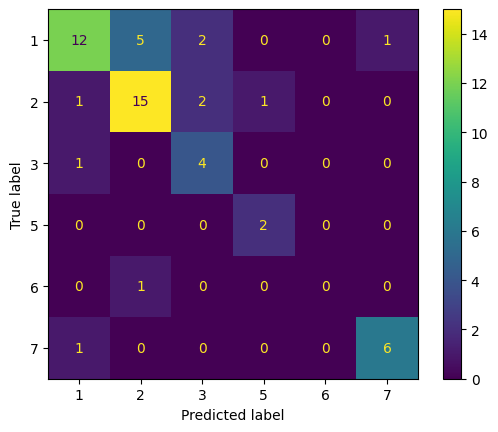

Accuracy: 0.7222
Precision: 0.7297
Recall: 0.7222
F1 Score: 0.7156


In [13]:
clf = DecisionTreeClassifier()
clf, X_test, y_test = train_model(clf, Glass)
plot_confusion_matrix(clf, X_test, y_test)
get_and_print_stats(clf, X_test, y_test)

<h1>Bagging Test</h1>

In [39]:
bagging_results = test_classifier(BaggingTester())

  0%|          | 0/504 [00:00<?, ?it/s]

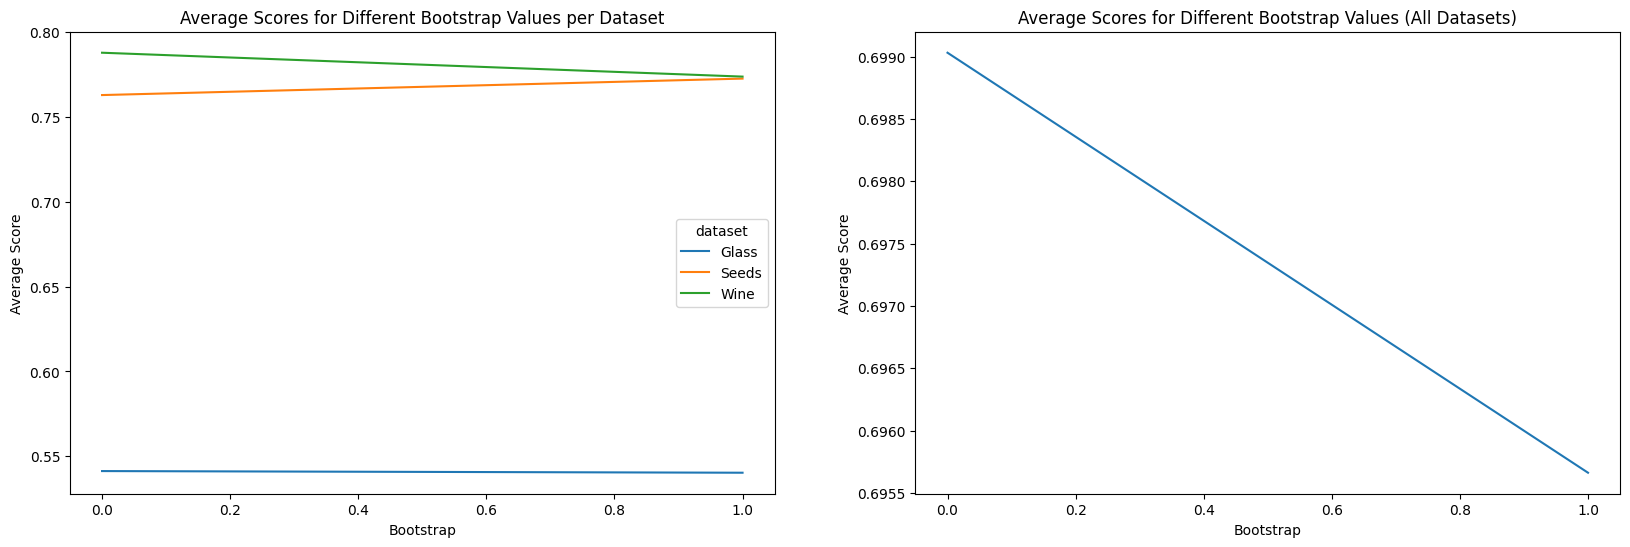

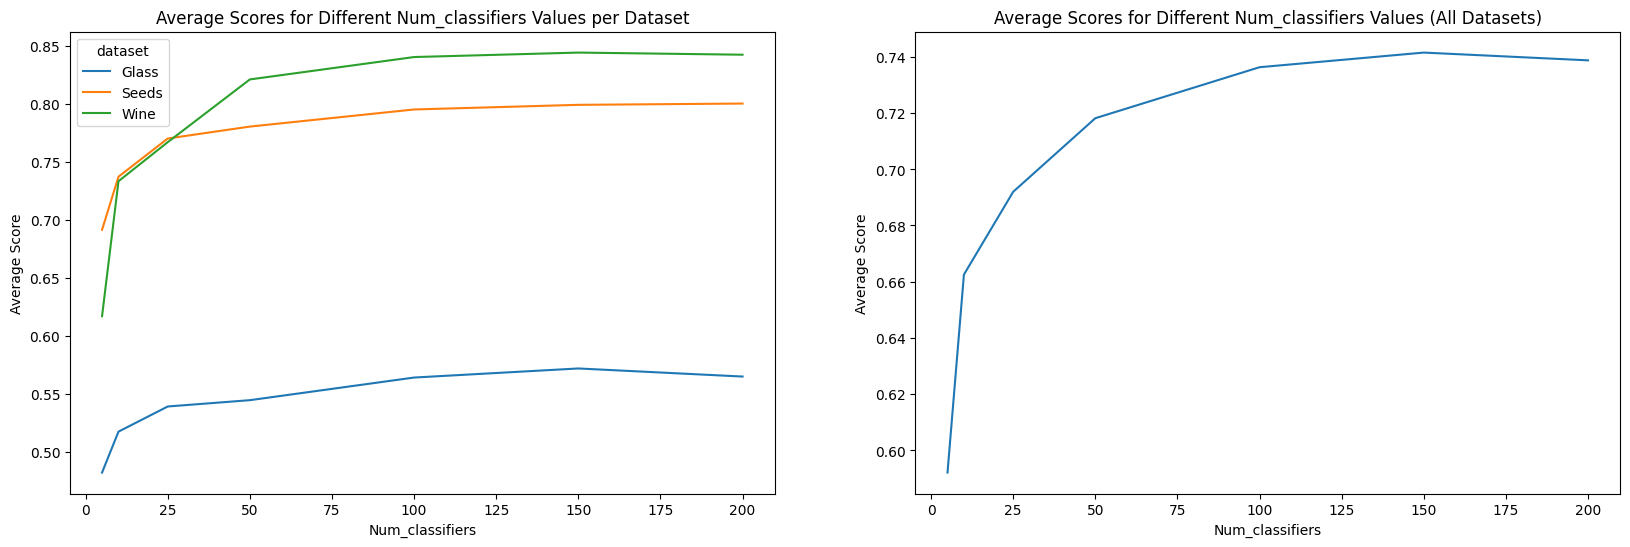

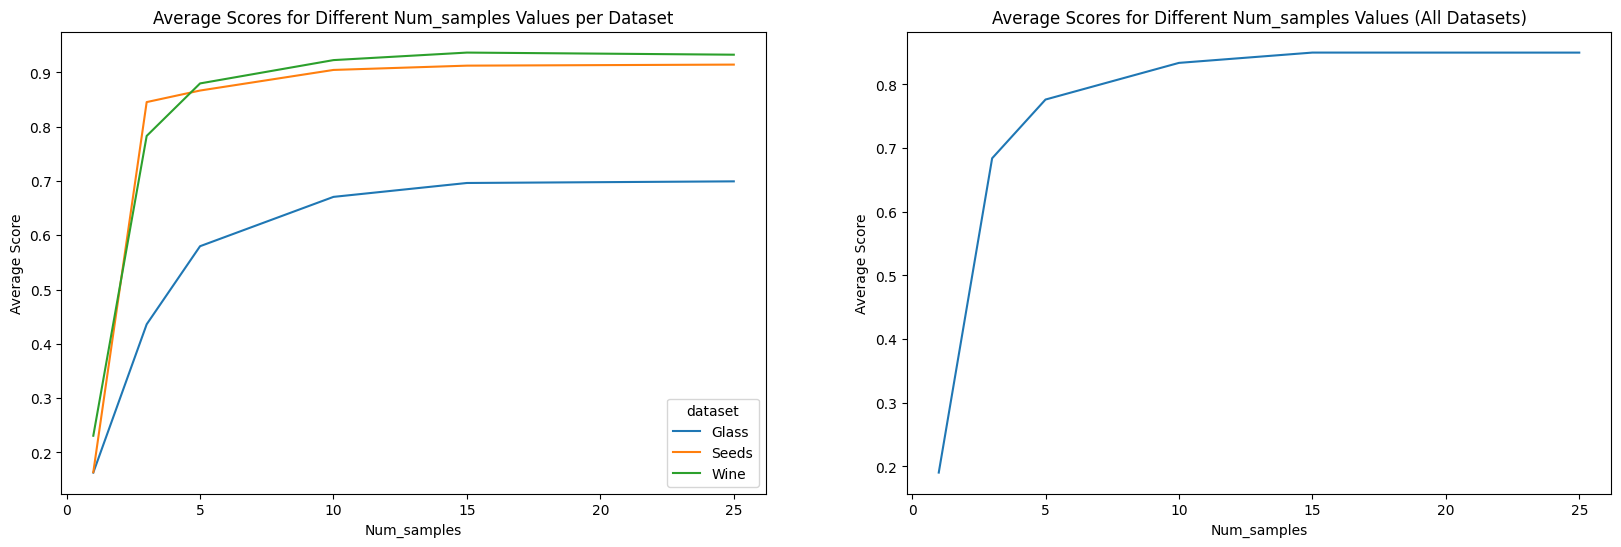

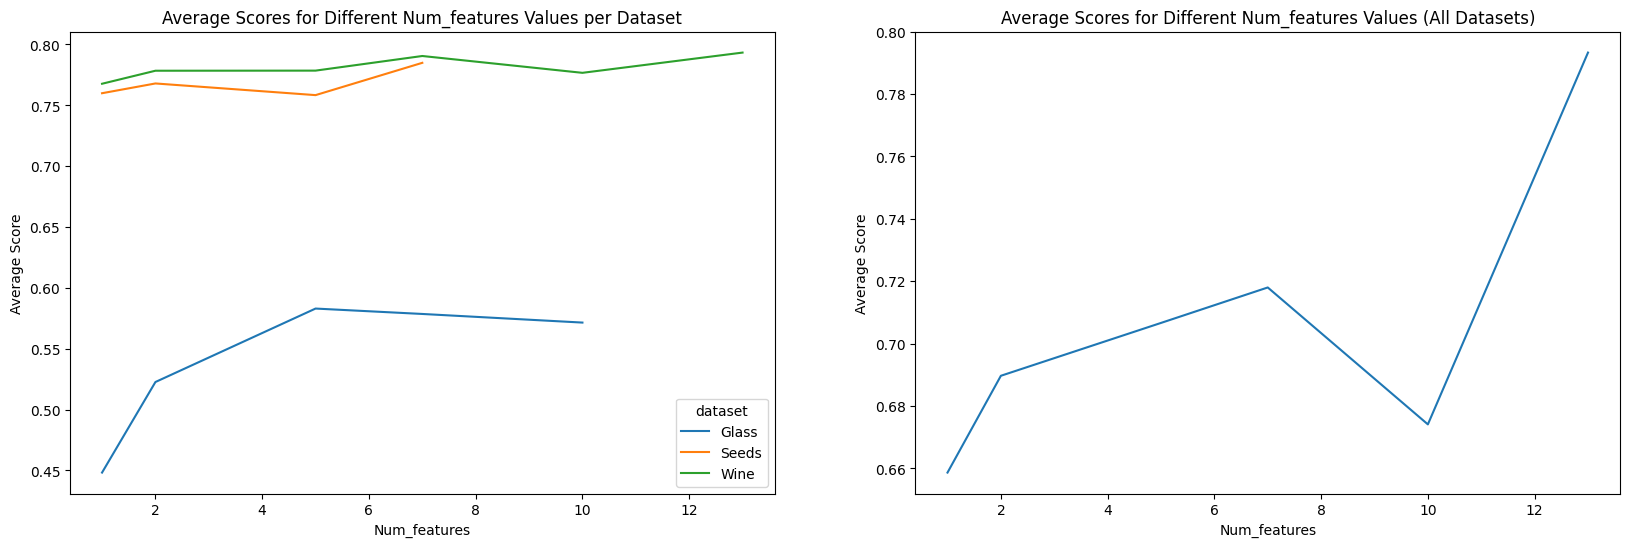

In [40]:
plot_all_avg_scores(bagging_results, BaggingTester.get_param_names())

<h1>AdaBoost Test</h1>

In [12]:
adaboost_results = test_classifier(AdaBoostTester())

  0%|          | 0/45 [00:00<?, ?it/s]

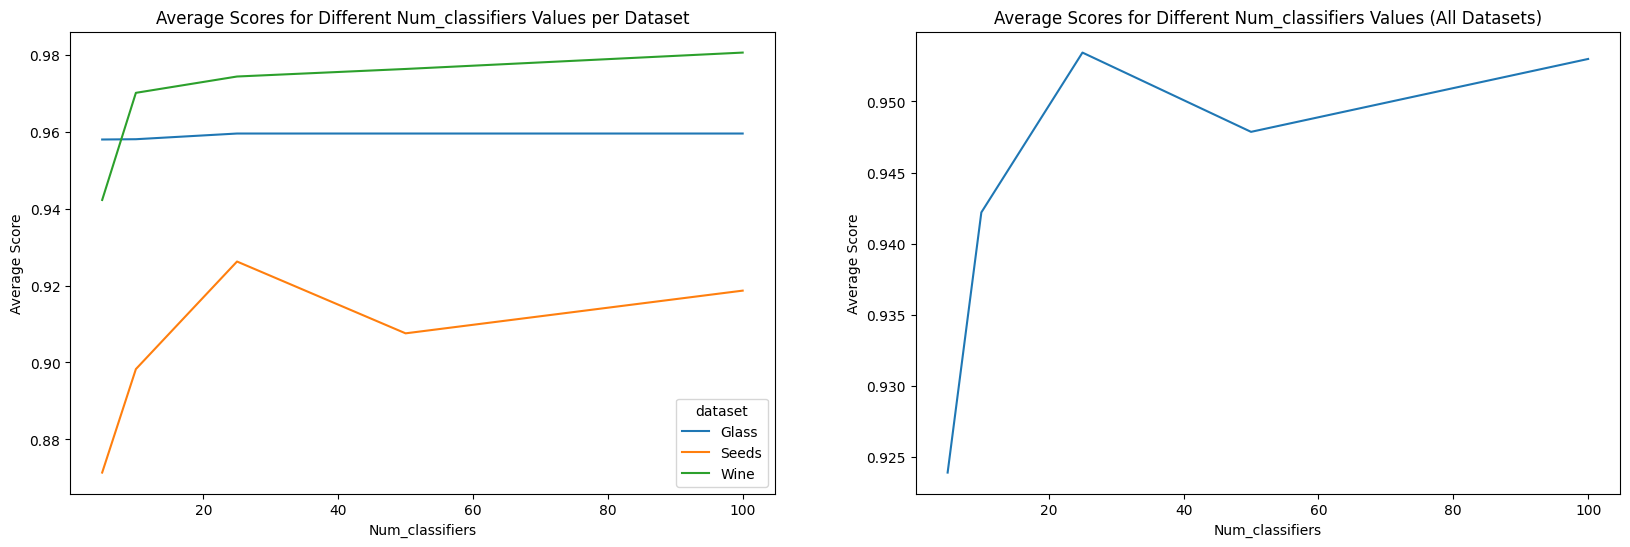

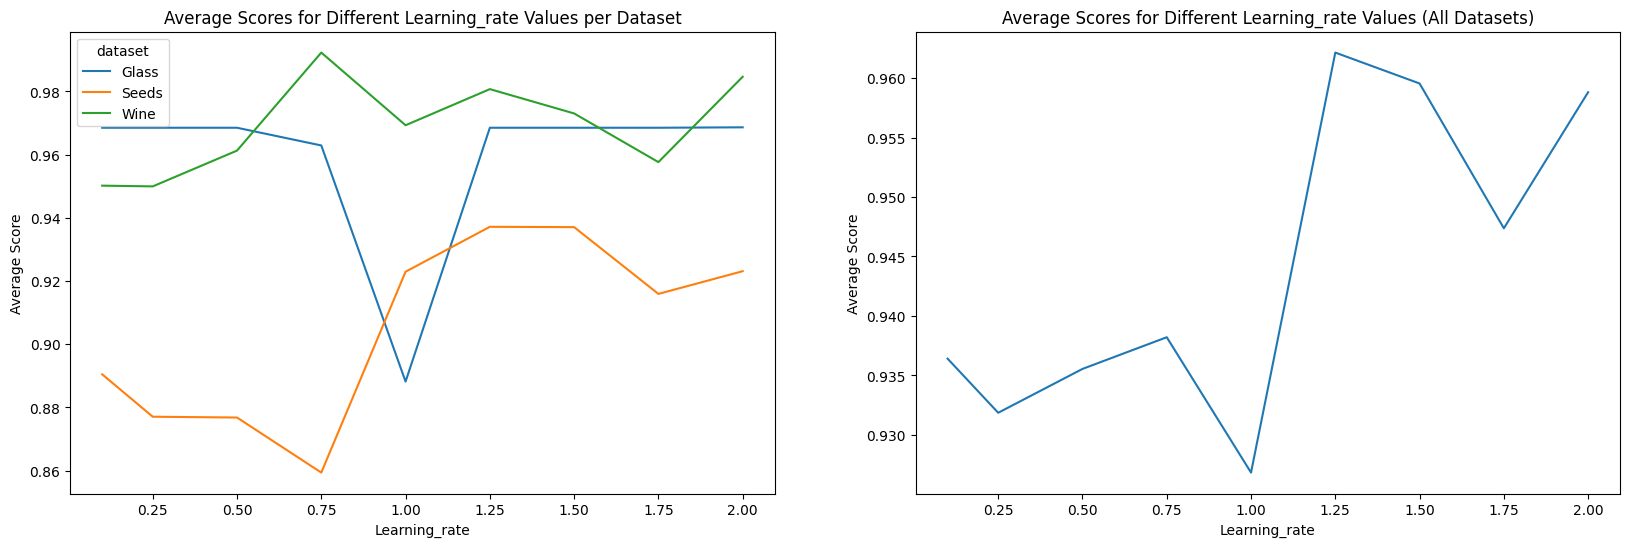

In [13]:
plot_all_avg_scores(adaboost_results, AdaBoostTester.get_param_names())

<h1>RandomForest Test</h1>

In [14]:
randomforest_results = test_classifier(RandomForestTester())

  0%|          | 0/576 [00:00<?, ?it/s]

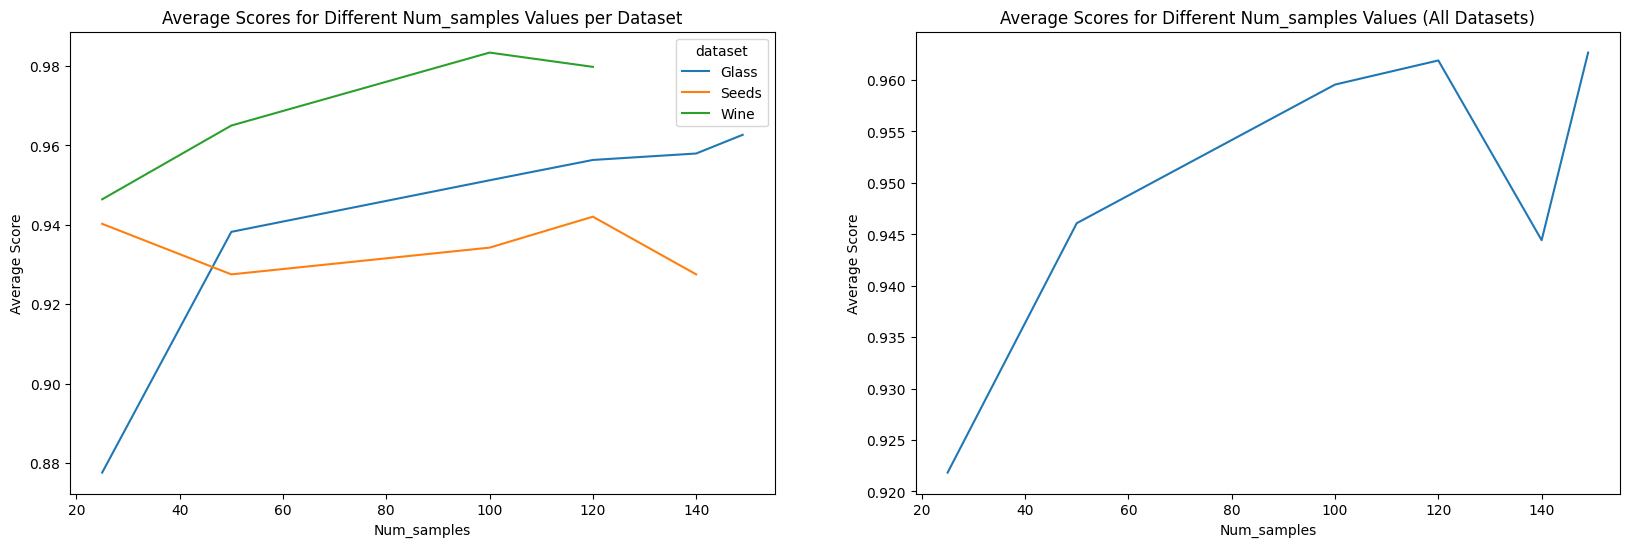

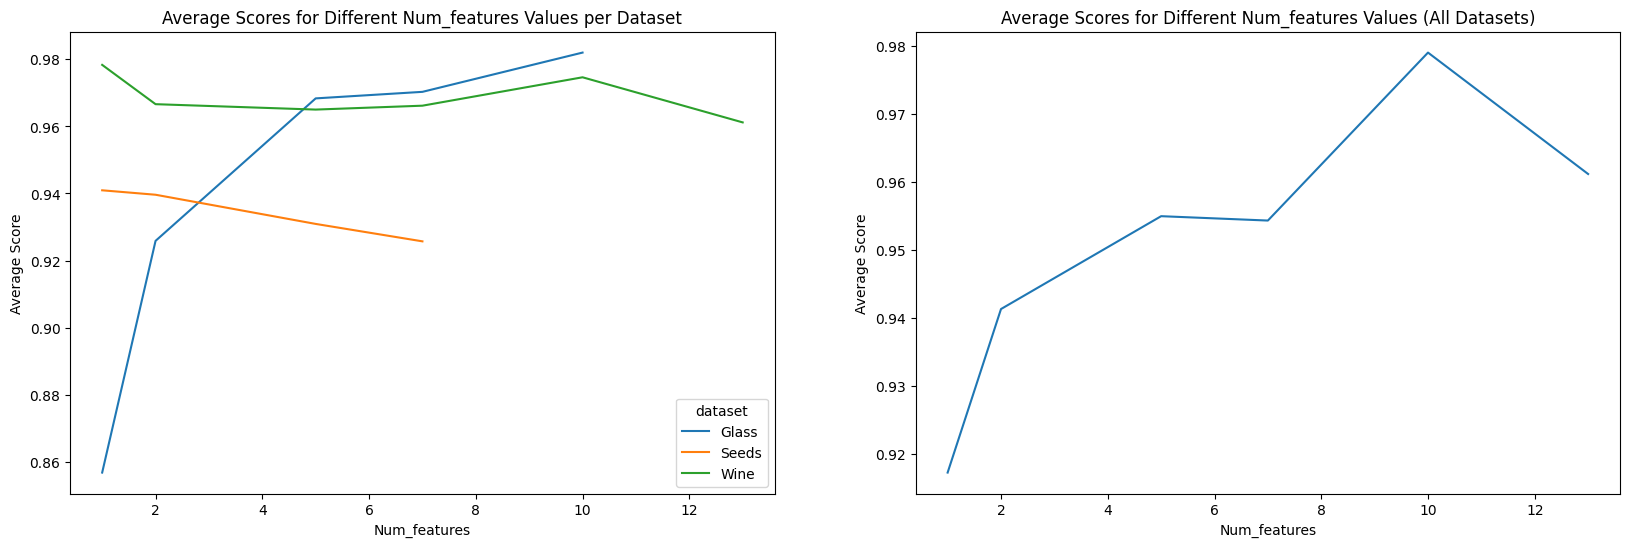

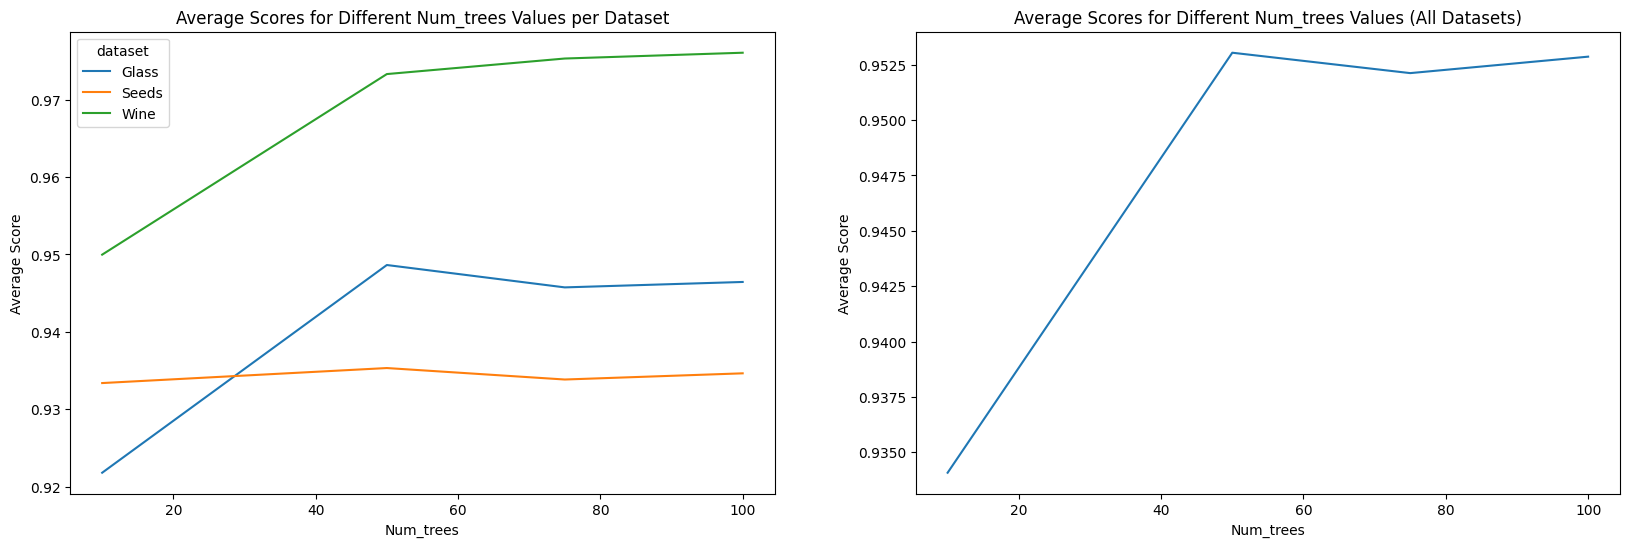

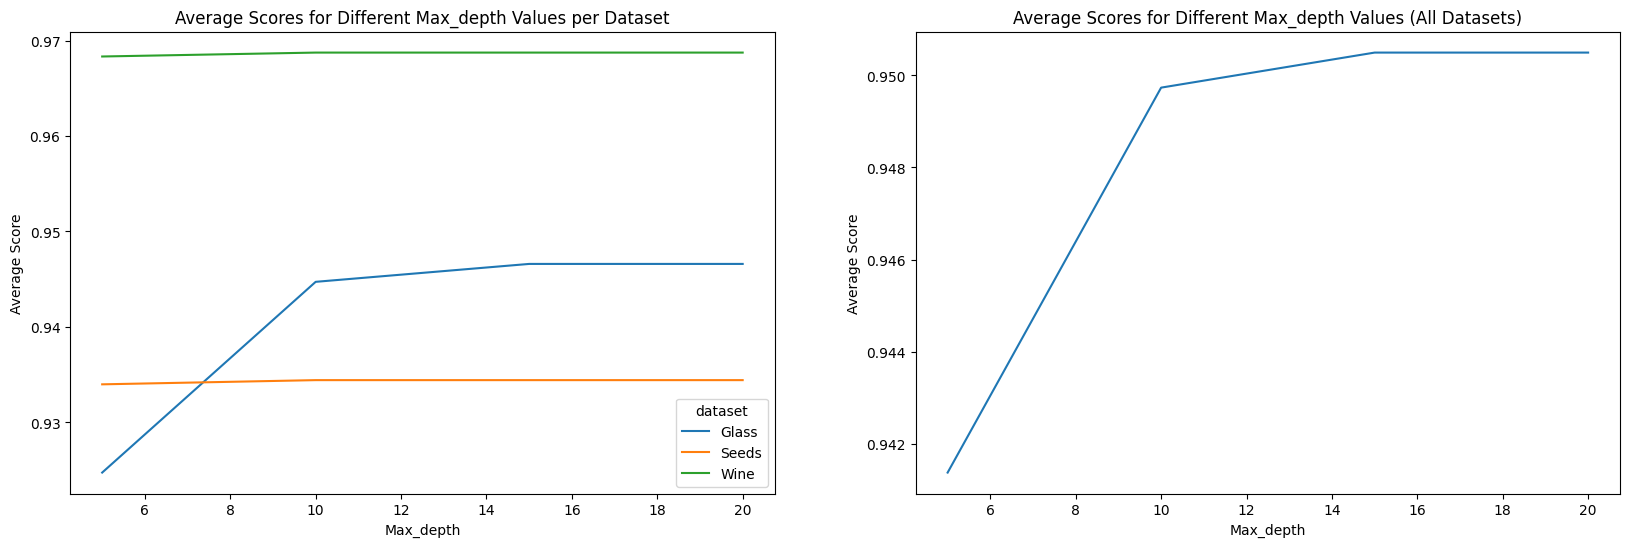

In [15]:
plot_all_avg_scores(randomforest_results, RandomForestTester.get_param_names())

<h1>Zestawienie najlepszych konfiguracji</h1>

In [80]:
def plot_classfiers(df: pd.DataFrame, dataclass: Type[DataClass] = None):
    plt.figure(figsize=(15,6))
    barplot = sns.barplot(data=df, x='classifier', y='f_score', palette='viridis')
    base_title = 'Top Results for Each Classifier'
    title = base_title if dataclass is None else f'{[dataclass.__name__]}: ' + base_title
    plt.title(title)
    plt.xlabel('Classifier')
    plt.ylabel('F_score')
    difference = (df['f_score'].max() - df['f_score'].min()) / 2
    plt.ylim(df['f_score'].min() - difference, 1.0)

    for p in barplot.patches:
        barplot.text(x = p.get_x() + p.get_width() / 2, 
                    y = p.get_height(),
                    s = "{:.6f}".format(p.get_height()), 
                    ha = 'center', color='black')

    plt.show()

def show_best_results(dataclass: Type[DataClass] = None):
    bagging_best = get_average_for_all_params(bagging_results, BaggingTester.get_param_names(), dataclass)
    adaboost_best = get_average_for_all_params(adaboost_results, AdaBoostTester.get_param_names(), dataclass)
    randomforest_best = get_average_for_all_params(randomforest_results, RandomForestTester.get_param_names(), dataclass)

    bagging_best['classifier'] = 'Bagging'
    adaboost_best['classifier'] = 'AdaBoost'
    randomforest_best['classifier'] = 'RandomForest'

    combined_top3 = pd.concat([bagging_best, adaboost_best, randomforest_best])
    combined_top3 = combined_top3.sort_values(by='f_score', ascending=False)

    plot_classfiers(combined_top3, dataclass)
    
    for classifier_df in [bagging_best, adaboost_best, randomforest_best]:
        classifier_name = classifier_df['classifier'].values[0]
        best_params = classifier_df.drop(columns=["f_score", "classifier"]).iloc[0].to_dict()
        print(f"Best parameters for {classifier_name}: {best_params}")

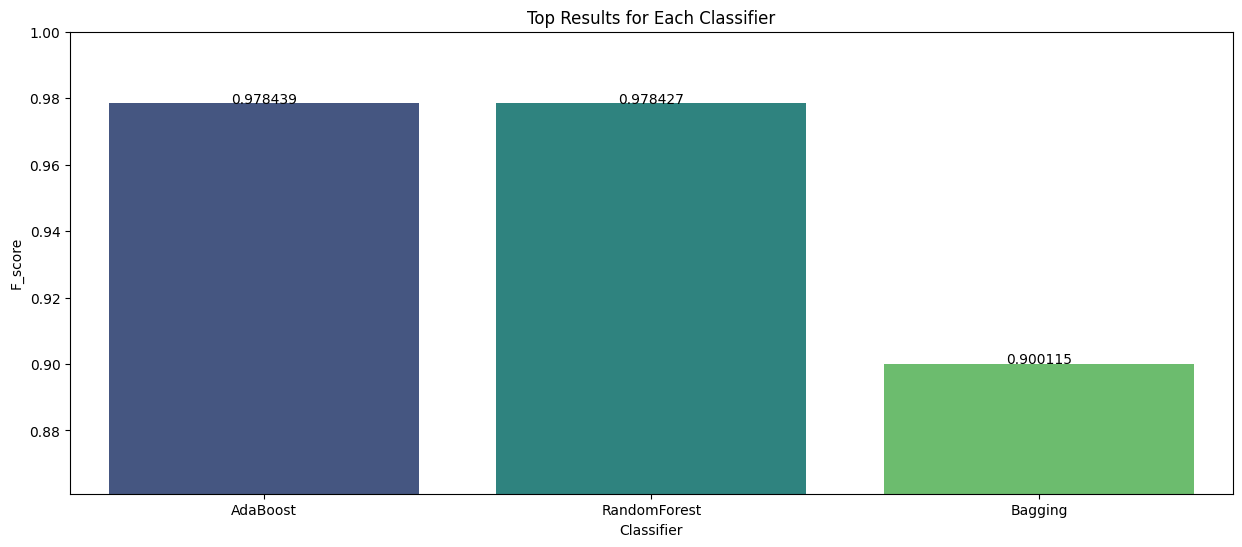

Best parameters for Bagging: {'bootstrap': True, 'num_classifiers': 150, 'num_samples': 15, 'num_features': 7}
Best parameters for AdaBoost: {'num_classifiers': 25.0, 'learning_rate': 2.0}
Best parameters for RandomForest: {'num_samples': 120, 'num_features': 2, 'num_trees': 100, 'max_depth': 15}


In [81]:
show_best_results()

Wyniki F-score dla każdej z trzech metod (Bagging, AdaBoost, RandomForest) są bardzo wysokie, co sugeruje, że wszystkie trzy algorytmy osiągają znakomite rezultaty w zakresie dokładności predykcji na podanych zestawach danych (Wine, Glass, Seeds)

Mimo że wszystkie metody osiągają dobre wyniki, AdaBoost i RandomForest mają nieznacznie lepsze F-score, co wskazuje, że mogą być bardziej skuteczne w przewidywaniu na tych zestawach danych

Ważne jest, aby zauważyć, że liczba wykorzystanych cech może mieć istotny wpływ na skuteczność klasyfikacji a ponieważ różnie datasety mają różna ilość cech te konfiguracje nie są optymalne dla poszczególnych zestawów danych.

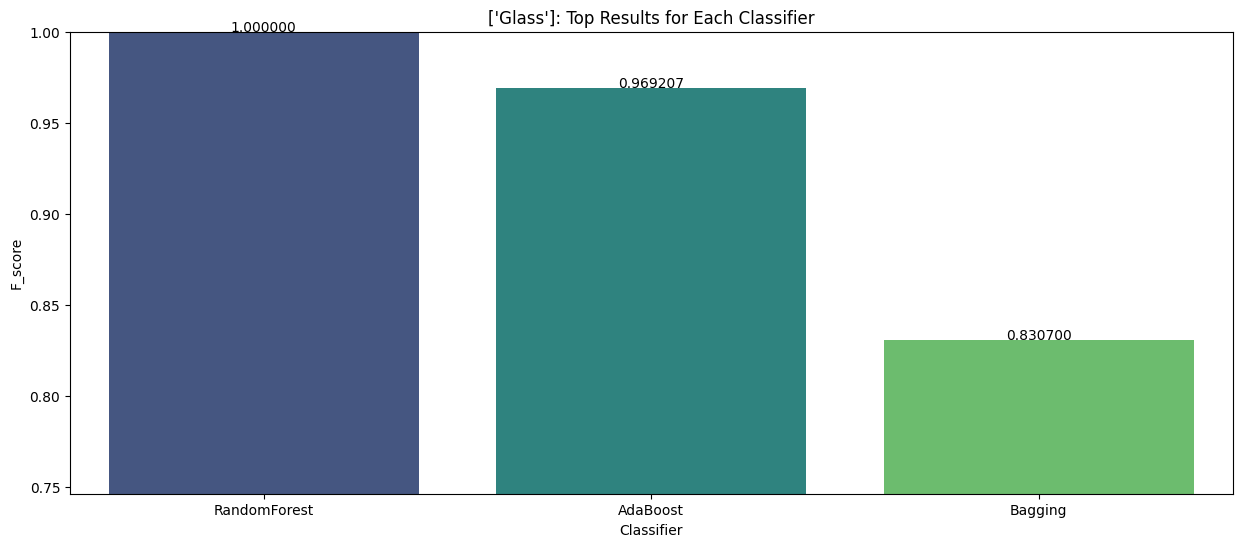

Best parameters for Bagging: {'bootstrap': True, 'num_classifiers': 10, 'num_samples': 10, 'num_features': 5}
Best parameters for AdaBoost: {'num_classifiers': 10.0, 'learning_rate': 2.0}
Best parameters for RandomForest: {'num_samples': 25, 'num_features': 10, 'num_trees': 10, 'max_depth': 20}


In [82]:
show_best_results(Glass)


Dla RandomForest, wynik F-score 1.0 sugeruje, że ten algorytm jest w stanie doskonale klasyfikować obiekty w zestawie danych Glass, co może sugerować, że cechy w tym zestawie danych są wyjątkowo informatywne i dobrze oddzielają różne klasy.

Bagging, mimo wykorzystania bootstrapingu i mniej klasyfikatorów, wydaje się być mniej skuteczny na tym zestawie danych w porównaniu do AdaBoost i RandomForest. Może to sugerować, że dla tego konkretnego zestawu danych, zestaw cech lub ich dystrybucja może nie być odpowiednia dla tego algorytmu.



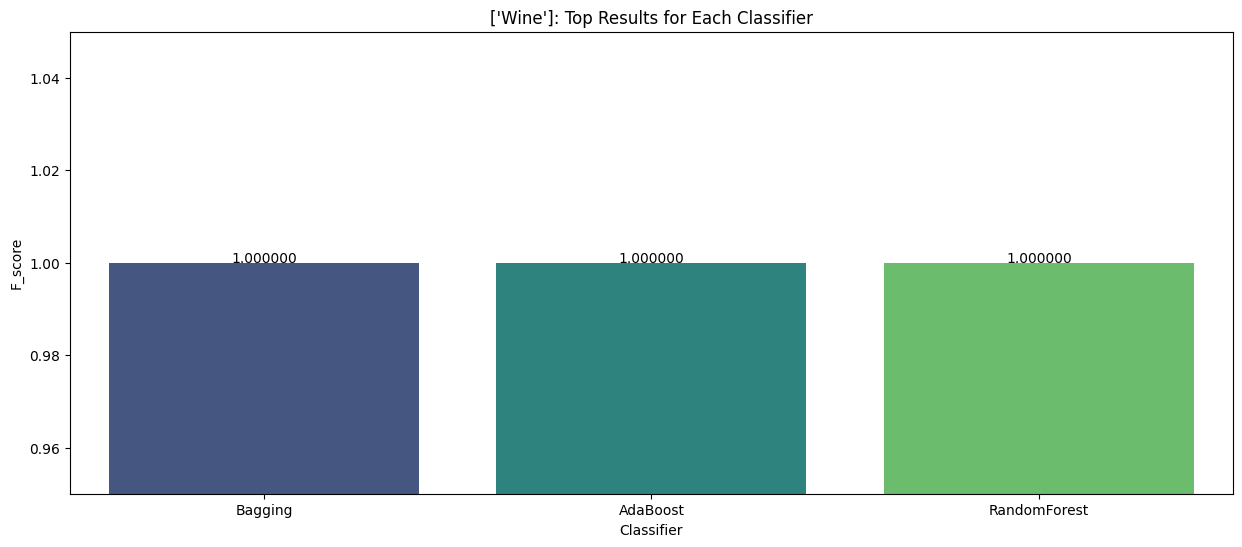

Best parameters for Bagging: {'bootstrap': True, 'num_classifiers': 200, 'num_samples': 15, 'num_features': 1}
Best parameters for AdaBoost: {'num_classifiers': 10.0, 'learning_rate': 0.75}
Best parameters for RandomForest: {'num_samples': 100, 'num_features': 10, 'num_trees': 10, 'max_depth': 10}


In [83]:
show_best_results(Wine)

Te wyniki potwierdzają, że różne algorytmy i różne zestawy danych mogą wymagać różnych hiperparametrów do osiągnięcia optymalnych wyników. Dla zestawu danych Wine, na przykład, metoda Bagging wymaga znacznie większej liczby klasyfikatorów i cech w porównaniu do wcześniejszych zestawów danych.

drzewami i maksymalną głębokością 10, co jest mniej niż w wcześniejszych zestawach danych, co ponownie podkreśla wpływ hiperparametrów na wydajność.

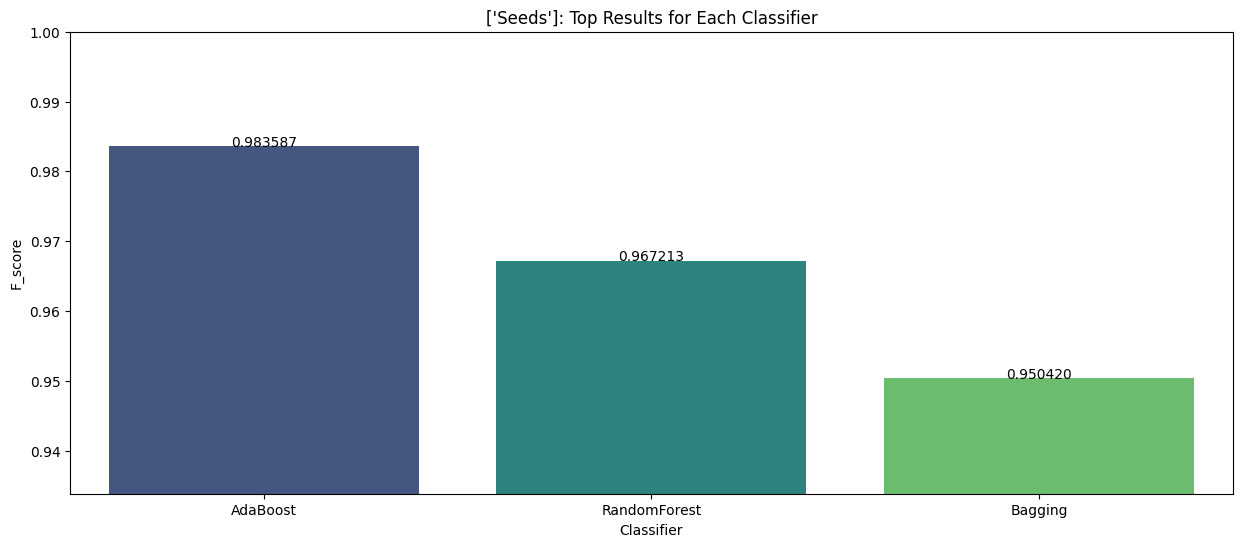

Best parameters for Bagging: {'bootstrap': True, 'num_classifiers': 50, 'num_samples': 10, 'num_features': 5}
Best parameters for AdaBoost: {'num_classifiers': 10.0, 'learning_rate': 1.0}
Best parameters for RandomForest: {'num_samples': 50, 'num_features': 1, 'num_trees': 10, 'max_depth': 10}


In [84]:
show_best_results(Seeds)

Wszystkie trzy algorytmy - Bagging, AdaBoost i RandomForest - wykazują wysokie wyniki F-score dla tego zestawu danych, co wskazuje na ich dobrą skuteczność w klasyfikacji próbek.

Ważne jest zauważenie, że dla metody RandomForest, optymalne wyniki osiągnięto z jedną cechą. To może sugerować, że jedna cecha jest wyjątkowo informatywna dla klasyfikacji próbek w tym zestawie danych.

<h1>Czy walidacja krzyżowa jest potrzebna</h1>

AdaBoost, Bagging i RandomForest mają wbudowane mechanizmy, które przeciwdziałają przeuczeniu. Wszystkie trzy techniki polegają na tworzeniu "zbioru" modeli, które są potem agregowane, aby zrobić końcową prognozę. To podejście często prowadzi do modeli, które są bardziej odporne na przeuczenie, ponieważ mają one zdolność do "uśredniania" błędów poszczególnych modeli w zespole.

Random Forest oraz Bagging używają techniki out-of-bag (OOB) error estimation, która jest podobna do walidacji krzyżowej. W trakcie tworzenia lasu, dla każdego drzewa pewna część próbek (ok. 37%) nie jest używana (tzw. "worki" danych). Na tych nieużywanych próbkach można potem testować model, dając niezależną ocenę błędu.

OOB error estimation może dostarczyć szacunków błędów, nie daje on pełnego obrazu tego, jak model będzie działał na niezależnym zestawie danych. Walidacja krzyżowa może dostarczyć dodatkowego potwierdzenia, że model jest stabilny i nie jest przeuczony.

Walidacja krzyżowa jest bardziej elastyczna i może być dostosowana do konkretnych sytuacji. Na przykład, można użyć walidacji krzyżowej stratyfikowanej, jeśli klasy są nierówno zrównoważone, co może nie być możliwe z OOB.

Jeżeli wybieramy optymalne hiperparametry dla naszych modeli, na przykład liczba cech ('num_features'), a nasz model pokazuje bardzo dobre wyniki, to może nie być konieczne wykonywanie walidacji krzyżowej.

Również możńa zobaczyć ,że w najlepszych konfiguracjach random forest oraz bagging nie zawsze wykorzystują wszystkie dostępne cechy co oznacza mniejsze ryzyko przeuczenia bo model jest mniej skomplikowany. Zmniejsza to również potrzebe walidacji krzyżowej.


<h1>Porównianie z bazowymi klasyfikatorami</h1>

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def compare_results(dataclass: Type[DataClass]):
    bagging_best = get_average_for_all_params(bagging_results, BaggingTester.get_param_names(), dataclass)
    adaboost_best = get_average_for_all_params(adaboost_results, AdaBoostTester.get_param_names(), dataclass)
    randomforest_best = get_average_for_all_params(randomforest_results, RandomForestTester.get_param_names(), dataclass)
    
    bagging_best['classifier'] = 'Bagging'
    adaboost_best['classifier'] = 'AdaBoost'
    randomforest_best['classifier'] = 'RandomForest'

    combined_top3 = pd.concat([bagging_best, adaboost_best, randomforest_best])
    
    combined_top3 = combined_top3.loc[:, ['classifier', 'f_score']]

    classifiers = [DecisionTreeClassifier, GaussianNB, LogisticRegression, KNeighborsClassifier, SVC]
    results = []
    for classifier in classifiers:
        clf, X_test, y_test = train_model(classifier(), dataclass)
        y_pred = clf.predict(X_test)
        _, _, _, _, f_score = classification_metrics(y_test, y_pred)  
        result_dict = {
            'classifier': classifier.__name__,
            'f_score': f_score
        }
        
        results.append(result_dict)
        
    df = pd.DataFrame(results)
    combined = pd.concat([df, combined_top3]).sort_values(by='f_score', ascending=False).reset_index(drop=True)
    plot_classfiers(combined, dataclass)
    print(combined)
        

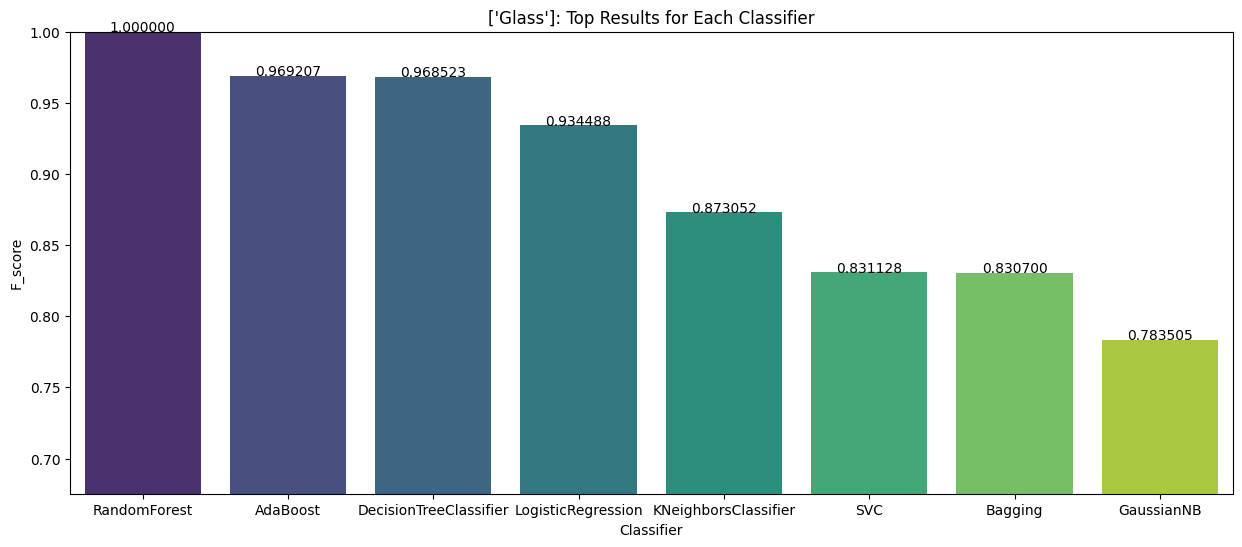

               classifier   f_score
0            RandomForest  1.000000
1                AdaBoost  0.969207
2  DecisionTreeClassifier  0.968523
3      LogisticRegression  0.934488
4    KNeighborsClassifier  0.873052
5                     SVC  0.831128
6                 Bagging  0.830700
7              GaussianNB  0.783505


In [92]:
compare_results(Glass)

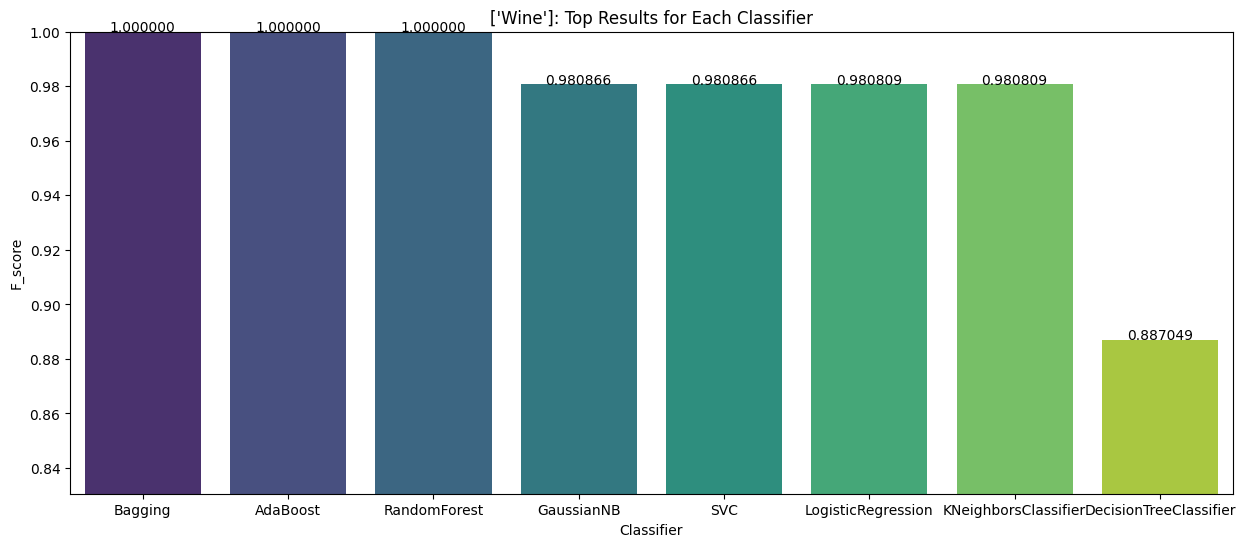

               classifier   f_score
0                 Bagging  1.000000
1                AdaBoost  1.000000
2            RandomForest  1.000000
3              GaussianNB  0.980866
4                     SVC  0.980866
5      LogisticRegression  0.980809
6    KNeighborsClassifier  0.980809
7  DecisionTreeClassifier  0.887049


In [93]:
compare_results(Wine)

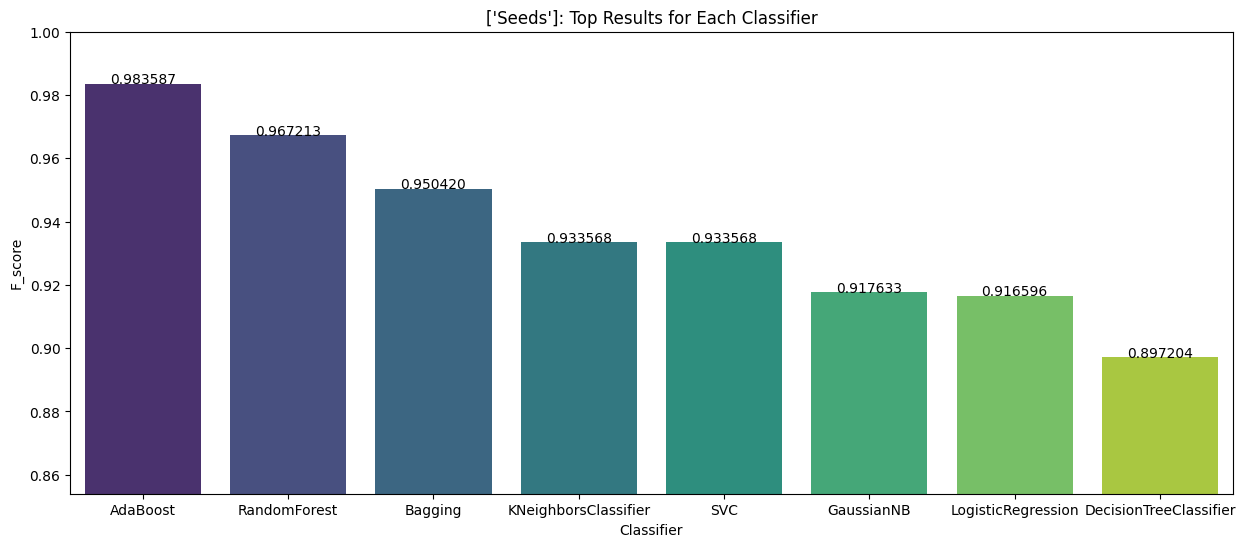

               classifier   f_score
0                AdaBoost  0.983587
1            RandomForest  0.967213
2                 Bagging  0.950420
3    KNeighborsClassifier  0.933568
4                     SVC  0.933568
5              GaussianNB  0.917633
6      LogisticRegression  0.916596
7  DecisionTreeClassifier  0.897204


In [94]:
compare_results(Seeds)

<h1>Zakończenie</h1>

W każdym zestawie danych, algorytmy ensemble, takie jak RandomForest, AdaBoost i Bagging, zwykle osiągają wyższe wyniki F-score w porównaniu do innych klasyfikatorów.

Ogólnie rzecz biorąc, klasyfikatory ensemble, takie jak Bagging, AdaBoost i RandomForest, zwykle osiągają lepszą wydajność w porównaniu do podstawowych klasyfikatorów. Jest to spowodowane zastosowaniem paru mechanizmów.

Algorytmy ensemble, takie jak Bagging, tworzą wiele estymatorów bazowych, które są trenowane na różnych podzbiorach danych. Ta różnorodność estymatorów pozwala modelowi lepiej generalizować, ponieważ każdy estymator może uczyć się nieco innego aspektu danych.

AdaBoost, jako przykład algorytmu boosting, działa poprzez sekwencyjne trenowanie estymatorów w taki sposób, że każdy kolejny estymator stara się poprawić błędy poprzedniego. To pozwala na redukcję zarówno błędu bias, jak i wariancji.

Algorytmy typu RandomForest łączą idee baggingu i random subspace, co prowadzi do silnych i stabilnych modeli. Przez tworzenie drzew decyzyjnych z różnymi podzbiorami cech, RandomForest jest w stanie zredukować wariancję bez zwiększania biasu.

<h1>Pytania pomocnicze</h1>

2. Czym różnią się algorytmy badane w zadaniu?

Bagging (Bootstrap Aggregating): Bagging polega na generowaniu wielu podzbiorów zestawu treningowego za pomocą bootstraping, a następnie trenowaniu niezależnego modelu dla każdego podzbioru. Następnie prognozy są kombinowane za pomocą większościowego systemu głosowania dla problemów klasyfikacji lub uśredniania dla problemów regresji. Głównym celem baggingu jest redukcja wariancji, a nie obciążenia.

AdaBoost (Adaptive Boosting): AdaBoost tworzy zespół słabych modeli. Każdy model jest trenowany na danych, które są różnie ważone, a te wagi są dostosowywane tak, aby kolejny model skupił się na trudniejszych do klasyfikacji przypadkach. W ten sposób AdaBoost stara się poprawić wydajność modelu. Algorytm AdaBoost ma tendencję do bycia bardziej podatny na overfitting w porównaniu do innych metod zespołowych.

Random Forest: Random Forest to rozwinięcie Baggingu, w którym dodatkowo dla każdego węzła drzewa wybierana jest losowa podgrupa cech. Dzięki temu tworzone są bardziej różnorodne drzewa, co pomaga zredukować wariancję. Random Forest jest mniej podatny na overfitting w porównaniu do AdaBoost, ale może wymagać więcej zasobów obliczeniowych, ze względu na większą liczbę drzew i ich większą głębokość.

3. Który z algorytmów jest łatwiejszy do zrozumienia?

Bagging jest stosunkowo prosty do zrozumienia, ponieważ polega na generowaniu wielu niezależnych modeli (najczęściej drzew decyzyjnych) na różnych podzbiorach zestawu treningowego, a następnie na uśrednieniu 
ich przewidywań.

AdaBoost jest nieco trudniejszy do zrozumienia, ponieważ tworzy sekwencję modeli, gdzie każdy kolejny model jest dostosowywany do poprawy wydajności na przypadkach, które były źle klasyfikowane przez poprzednie modele. Wymaga to zrozumienia, jak wagi są aktualizowane i jak wpływa to na proces uczenia.

Random Forest jest zasadniczo rozwinięciem Baggingu i jest stosunkowo łatwy do zrozumienia, jeśli zna się zasady działania drzew decyzyjnych i Baggingu. Trudność może polegać na zrozumieniu, jak losowy wybór cech na każdym podziale drzewa pomaga zwiększyć różnorodność modelu i zredukować wariancję.

4. Który z algorytmów łatwiej dostroić?
   
Bagging ??

AdaBoost jest bardziej podatny na overfitting i wymaga bardziej precyzyjnego dostrojenia hiperparametrów

Random forest jest mało podatny na overfitting tak więc nie wymaga precyzyjnego dostrajania.

5. Który z algorytmów ma najlepszą skuteczność a który z nich ma najlepszą
efektywność (zdefiniowaną roboczo jako „czas przetwarzania”)? Kiedy to ma
znaczenie?

Jest to w dużej części zależne od hyperparametrów. Tak naprawde na datasetach (Seeds, Wine, Glass) wyniki często się różnią tylko po 3, 4 miejscu po przecinku ale czas ich wykonywania jest zanczania różny. 

6. Z czego składa się finalny model klasyfikacji dla poszczególnych algorytmów?
   
W Baggingu, finalny model składa się z wielu niezależnych modeli (często drzew decyzyjnych), każdy z nich trenowany na różnym podzbiorze danych treningowych, wygenerowanym za pomocą techniki zwanej bootstrap. Każdy podzbiór jest tworzony poprzez losowe pobieranie próbek z oryginalnego zestawu danych, ale z zamianą, co oznacza, że niektóre próbki mogą pojawić się więcej niż raz, a inne mogą nie zostać wybrane. 

W przypadku AdaBoost, finalny model również składa się z zespołu modeli, ale proces tworzenia tego zespołu jest bardziej dynamiczny. AdaBoost zaczyna od nauczenia pojedynczego modelu na pełnym zestawie danych, a następnie na podstawie błędów tego modelu modyfikuje wagi próbek, zwiększając wagi próbek, które były źle sklasyfikowane. Następnie AdaBoost trenuje kolejny model na tych zmodyfikowanych danych i proces ten jest powtarzany.

Tak jak Bagging, las losowy składa się z wielu drzew decyzyjnych, każde z nich trenowane na różnym podzbiorze danych generowanym za pomocą bootstrap. Jednak w przeciwieństwie do Baggingu, w RandomForest przy tworzeniu każdego węzła drzewa jest wybierana losowa podgrupa cech, a nie wszystkie cechy. To prowadzi do większej różnorodności w zespole i pomaga zredukować wariancję modelu.